In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.pyplot import MultipleLocator
from tslearn.piecewise import SymbolicAggregateApproximation
from hmmlearn.hmm import CategoricalHMM
import random
from sklearn.model_selection import KFold
from sklearn import preprocessing
import scipy.stats as stats
from scipy.stats import f_oneway

ImportError: cannot import name 'pinv2' from 'scipy.linalg' (d:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\__init__.py)

In [7]:
class participant:
    def __init__(self,PID):
        self.PID=PID
        self.D1_rating=[]
        self.D4_rating=[]
    def __str__(self):
        print("participant: "+self.PID)
        print("Visit 1: "+str(len(self.D1_rating)))
        print("Visit 4: "+str(len(self.D4_rating)))
        return ""
    def update_rating(self,D1,D4):
        self.D1_rating=D1
        self.D4_rating=D4

In [12]:
Carl_chronic_df=pd.read_pickle("../data/CBP_rating.pkl")
Carl_subacute_df=pd.read_pickle("../data/SBP_rating.pkl")
Carl_classify=pd.read_pickle("../data/class.pkl")
cbp_participant_list=[]
sbpr_participant_list=[]
sbpp_participant_list=[]
class_pain={}
for index,row in Carl_classify.iterrows():
    if row['subject'] not in class_pain:
        class_pain[row['subject']]=row['classification']
PID_list=[]
for index,row in Carl_chronic_df.iterrows():
    if row['PID'] not in PID_list:
        PID_list.append(row['PID'])
    else:
        continue
    if row['D1_rating']!=[] and row['D4_rating']!=[]:
        part=participant(row['PID'])
        part.update_rating(row['D1_rating'],row['D4_rating'])
        cbp_participant_list.append(part)
for index,row in Carl_subacute_df.iterrows():
    if row['PID'] not in PID_list:
        PID_list.append(row['PID'])
    else:
        continue
    if class_pain[row['PID']]=='SBPr':
        if row['D1_rating']!=[] and row['D4_rating']!=[]:
            part=participant(row['PID'])
            part.update_rating(row['D1_rating'],row['D4_rating'])
            sbpr_participant_list.append(part)
    elif class_pain[row['PID']]=='SBPp':
        if row['D1_rating']!=[] and row['D4_rating']!=[]:
            part=participant(row['PID'])
            part.update_rating(row['D1_rating'],row['D4_rating'])
            sbpp_participant_list.append(part)
    else:
        print(row['PID']+"error")

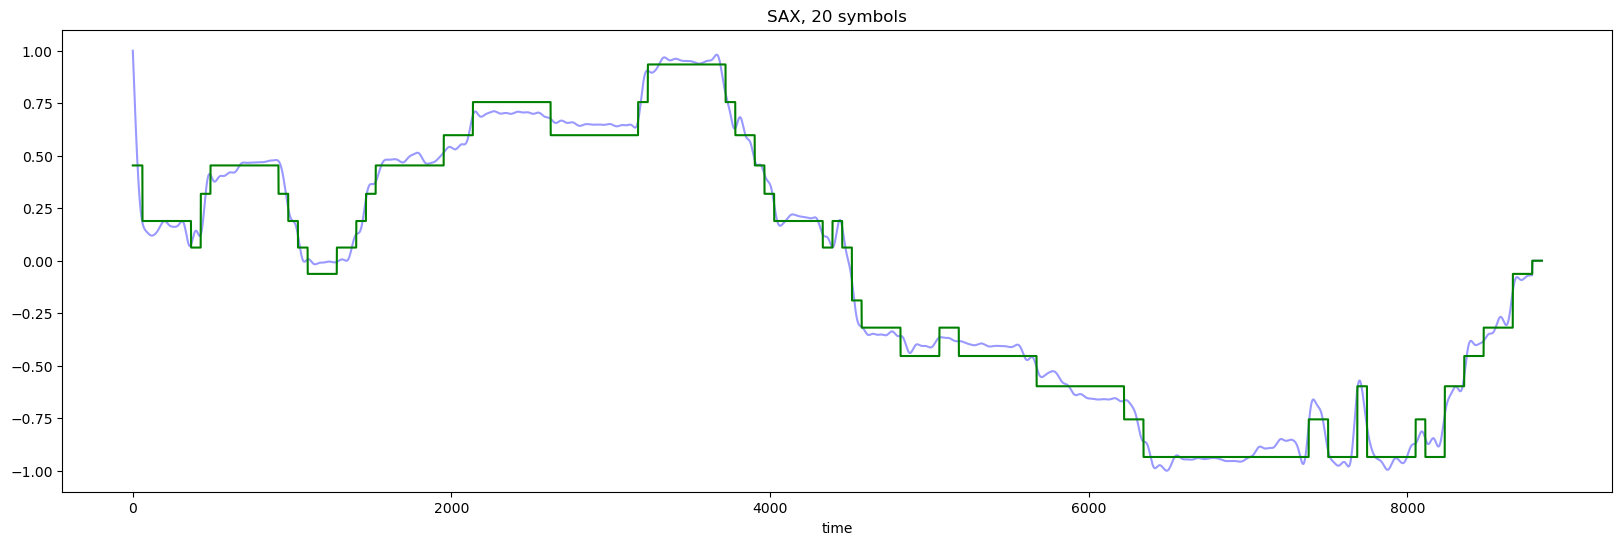

In [13]:
def add_dim(data):
    rating=np.array(data)
    rating_new=np.expand_dims(rating, 0)
    rating_new=np.expand_dims(rating_new, 2)
    return rating_new
def SAX_rating(rating,n_paa_segments,n_sax_symbols, plot=False):
    # print(len(rating))
    if type(rating)!=np.ndarray:
        rating=np.array(rating)
    rating_norm = (rating-np.min(rating))/(np.max(rating)-np.min(rating))
    rating_norm=np.array(rating_norm)*2-1
    add_length=int(len(rating)/n_paa_segments)
    rating_norm=rating_norm.tolist()+[0]*add_length
    rating=add_dim(rating_norm)
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                     alphabet_size_avg=n_sax_symbols)
    sax_dataset_inv = sax.inverse_transform(sax.fit_transform(rating))
    output=sax_dataset_inv[0].ravel()
    if plot==True:
        plt.figure(figsize=(20, 6))
        plt.plot(rating[0].ravel(), "b-", alpha=0.4)
        plt.plot(sax_dataset_inv[0].ravel(), "g-")
        plt.title("SAX, %d symbols" % n_sax_symbols)
        plt.xlabel("time")
        plt.show()
    return output[:-1*add_length]
Sax_sample=SAX_rating(cbp_participant_list[0].D1_rating,144,20,True)

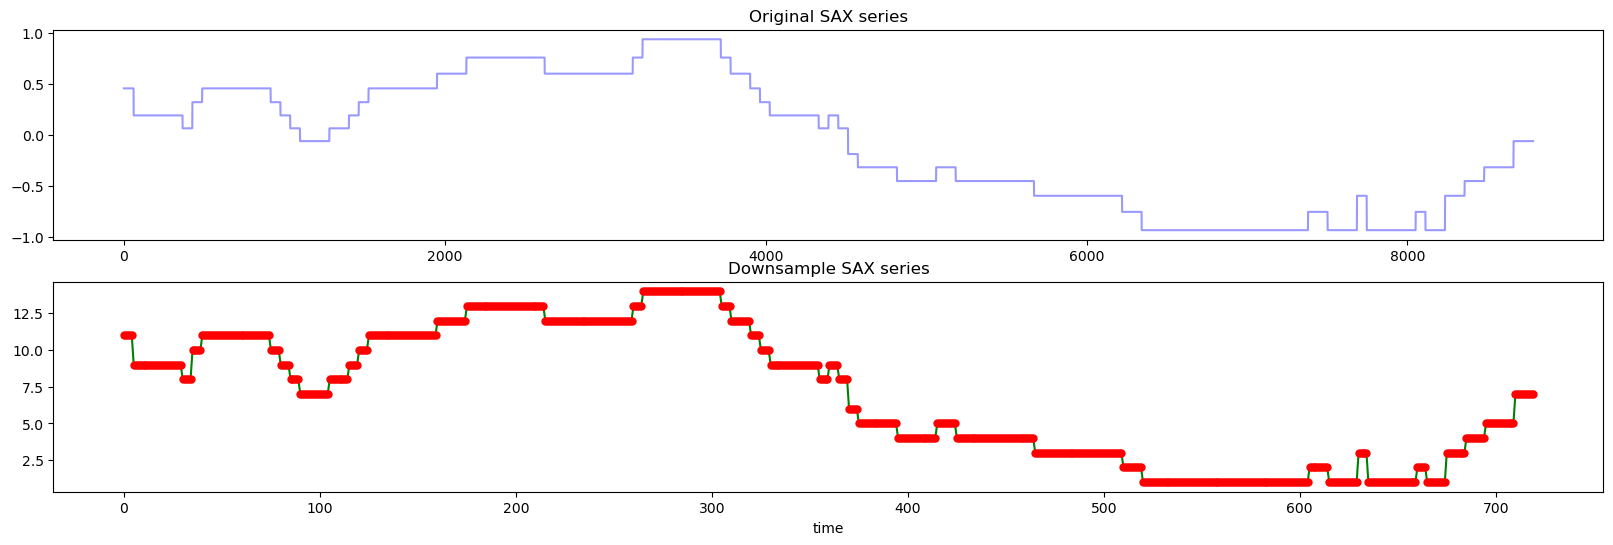

In [16]:
def downsample_SAX(SAX_rating,n_paa_segments,multi=1,plot=False):
    flat_length=int(len(SAX_rating)/n_paa_segments)
    downsample_SAX_list=[]
    label_set=sorted(set(SAX_rating))
    int_label_dic={}
    for label_i,label in enumerate(label_set):
        # print(label)
        int_label_dic[label]=label_i+1
    for point in SAX_rating[::flat_length]:
        for multi_i in range(multi):
            downsample_SAX_list.append(int_label_dic[point])
    if plot==True:
        # fig, ax = plt.subplots(2, 1)
        # fig.tight_layout()
        plt.figure(figsize=(20, 6))
        plt.subplot(2, 1, 1)
        plt.plot(SAX_rating.ravel(), "b-", alpha=0.4)
        plt.title("Original SAX series")
        plt.subplot(2, 1, 2)
        plt.plot(downsample_SAX_list, "g-",marker ='.',mfc='red', mec='red',ms=10)
        plt.title("Downsample SAX series")
        plt.xlabel("time")
        plt.show()
    return np.array(downsample_SAX_list)
n_paa=144
downsample_SAX_sample=downsample_SAX(Sax_sample,n_paa,multi=5,plot=True)

In [17]:
# Reshape the observed data to a 2D array (required by hmmlearn)
observed_SAX_rating_sample = downsample_SAX_sample.reshape(-1, 1)
# Create and train the Gaussian HMM model
num_states = 10
model_sample = CategoricalHMM(n_components=num_states)
model_sample.fit(observed_SAX_rating_sample)

CategoricalHMM(n_components=10, n_features=15,
               random_state=RandomState(MT19937) at 0x1AE41CEA240)

In [19]:
observed_SAX_rating_sample.shape

(720, 1)

In [21]:
import numpy as np
import pymc3 as pm
from hmmlearn import hmm

# Sample data for training the HMM (discrete observations)
observed_data = np.array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1])

# Define three Hidden Markov Models with different numbers of hidden states
num_states_list = [2, 3, 4]

# List to store the ELPD for each model
elpd_list = []

# Loop over each model and calculate ELPD
for num_states in num_states_list:
    with pm.Model() as model:
        # Create and fit a Hidden Markov Model with hmmlearn
        model_hmmlearn = hmm.MultinomialHMM(n_components=num_states, n_iter=100)
        model_hmmlearn.fit(observed_data.reshape(-1, 1))

        # Compute log-likelihood of the data under the trained HMM
        log_likelihoods = model_hmmlearn.score_samples(observed_data.reshape(-1, 1))[0]

        # Number of data points (sequence length)
        num_data_points = observed_data.shape[0]

        # Parameters for ELPD calculation
        elpd = pm.Data("elpd", log_likelihoods)
        sigma = pm.HalfCauchy("sigma", beta=1)

        # Deterministic transformation for calculating ELPD
        elpd_transformed = pm.Deterministic("elpd_transformed", pm.math.sum(elpd))

        # Likelihood of the data under the model
        likelihood = pm.Normal("likelihood", mu=elpd_transformed, sd=sigma, observed=0.0)

        # Perform MCMC sampling
        trace = pm.sample(2000, tune=1000, cores=1, random_seed=42)

    # Store the ELPD for this model
    elpd_list.append(np.sum(trace['elpd_transformed']))

# Compare the ELPD of the three models
for i, num_states in enumerate(num_states_list):
    print(f"Model with {num_states} hidden states: ELPD = {elpd_list[i]}")


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


ValueError: startprob_ must sum to 1 (got nan)